In this article, I discuss one of my submissions for the IMC prosperity trading competition.
In the first round, we were tasked to develop a trading strategy for a ficitional security called STARFRUIT.
We were given price data for 3 tading days, each day being divided into 10000 time stamps.

I) Cleaning the data

We received the data in CSV format but the content of the file was unusual, making it impossible to process with a regular csv reader:

![title](csv_file_initial_format.png)

The issue was with the arbitrary sequences of semicolons highlighted above. I dealt with them using the code below

In [4]:
import pandas as pd

# First, I create a function to remove duplicate semicolons from a string
def remove_duplicate_semicolons(text):
    text_list = text.split(";")
    new_text_list = [element for element in text_list if element != '']
    new_text = ";".join(new_text_list)
    return new_text

#Then I apply the function to each line in the input files
with open('prices_round_1_day_-2.csv',"r+") as f:
    s = f.read()
    s_2 = remove_duplicate_semicolons(s)
    f.write(s_2)
Prices_t_minus_2 = pd.read_csv('prices_round_1_day_-2.csv',delimiter = ";")
Prices_t_minus_2.head()

#Since the file contains the prices for other securities, I only select the prices for STARFRUIT and output them 
#to a new file
mydf2 = Prices_t_minus_2[Prices_t_minus_2['product']== 'STARFRUIT']['mid_price']
mydf2.to_csv('mid_price_minus_2_STARFRUIT.csv', index=False)

/Users/ismaelziediamoutene/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


II) Visualizing the data and finding a strategy

The prices for the 3 days came in different files. I combined the 3 tables in Excel to obtain the final output below.

<AxesSubplot:xlabel='time_stamp_final'>

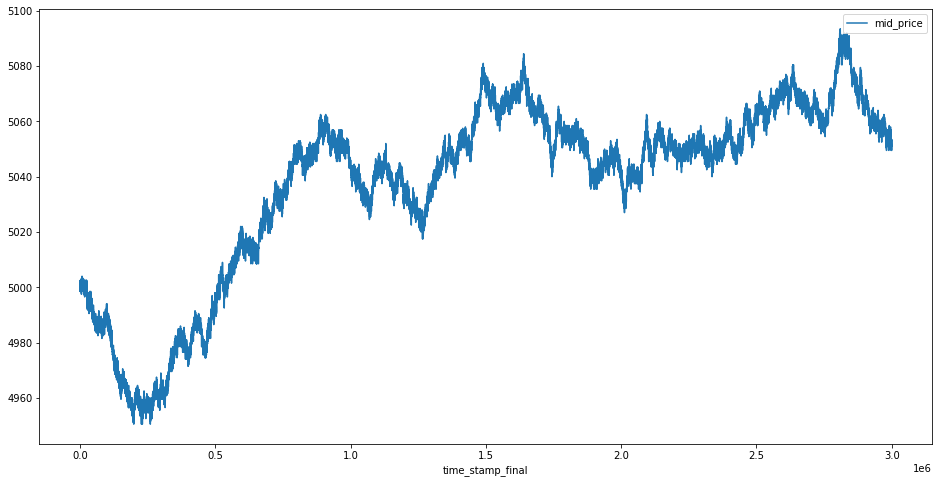

In [5]:
starfruit_df = pd.read_csv('Price starfruit final.csv')
starfruit_df.set_index('time_stamp_final',inplace = True)
starfruit_df.plot(figsize=(16, 8))

One thing We notice is that this chart is that there are a lot of trends. Those could be exploited to build a momentum strategy.

The key to build such a strategy would be to figure out when to enter a trend and when to exit. 

First, I separate the trend from the noise using a moving average smoothing.

I tried different windows length for the moving average and 200 periods was the smallest window that clearly outlined the trend. I choose the window lenghts arbitrarily, there are probably smaller window lengths with similar results. 

Below I implement the moving average and plot the results

<AxesSubplot:xlabel='time_stamp_final'>

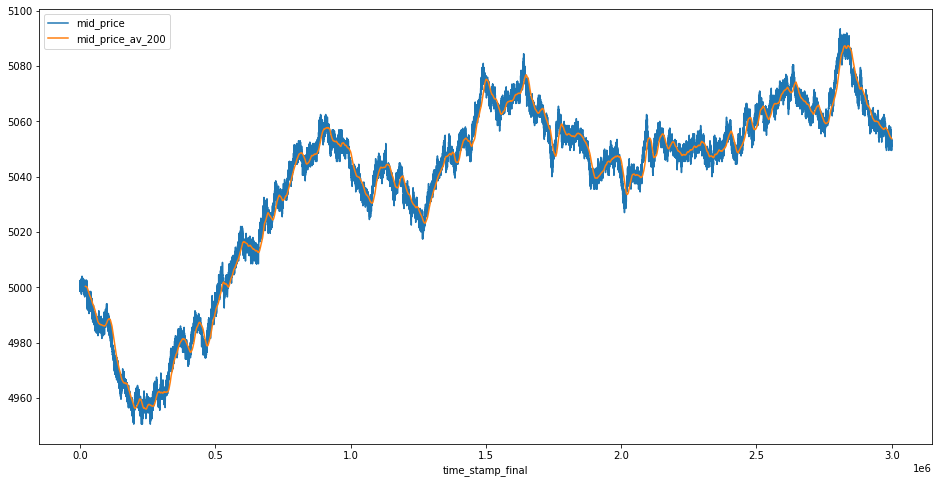

In [9]:
#Smoothing using 200 periods
starfruit_df_av_200 = pd.read_csv('Price starfruit final.csv')
starfruit_df_av_200.set_index('time_stamp_final',inplace = True)
starfruit_df_av_200['mid_price_av_200'] = starfruit_df_av_200['mid_price'].rolling(200).mean()
starfruit_df_av_200[['mid_price', 'mid_price_av_200']].plot(label='Moving average 200', 
                                  figsize=(16, 8))

as I explained above, the key to make this strategy work is to enter and exit then trend at the right time.

To determine the entry and exit signals, I use the sum of returns of the trend over a given period. I define the return at time t as the trend(smoothed price) at time t minus the trend(smoohtend price) at time t-1

A positive cumulative sum would mean that the trend is mostly upward sloping during that period (since the positve returns outweigh the negative returns). A negative cumulative sum would mean that the trend is mostly downward sloping during that period (Since the negative returns outweigh the positive returns).

I illustrate my point using the sketch below

![title](STARFRUIT_strategy.jpg)

I use a similar logic when the trend slopes downward then upward.

When we arrive at a sistuationsimilar to the 3rd picture above, I sell what I bought to profit from the previous upward momentum and short sell a new amount to profit from the new downward momentum.

I would do the opposite if we switch from a downward momentum to an upward momentum.

The window length I chose will be critical. I the window is too small, small deviations from the trend will trigger buy/sell orders while the trend keeps going in the same direction. If the window is too big, it will take too long for my algorithm to notice changes in the direction of the trend.

III) Implementing the strategy

Before I Implement the strategy, let's first undersand the "Market" mechanism in the competition.

- Every 100 time stamps, we receive some information from the exchange about the oustanding orders: buy orders(price and quantity), sell orders (price and quantity), as well as the mid price (average of the best ask and best bid). This information is stored in an object called TradingState.

- The contestants needed to create a class called "Trader" that takes as input the TradingState object of the current timestamp, as well as some info about the previous time stamps and output some orders. 

For now I focus on buying/selling/buying back/short selling 1 unit.
My goal is to see the performance of the strategy with this simple setup before I scale it.

III) Implementing the strategy

Before I Implement the strategy, let's first undersand the "Market" mechanism in the competition.

- Every 100 time stamps, we receive some information from the exchange about the oustanding orders: buy orders(price and quantity), sell orders (price and quantity), as well as the mid price (average of the best ask and best bid). This information is stored in an object called TradingState.

- The contestants needed to create a class called "Trader" that takes as input the TradingState object of the current timestamp, as well as some info about the previous time stamps and output some orders. 

For now I focus on buying/selling/buying back/short selling 1 unit.
My goal is to see the performance of the strategy with this simple setup before I scale it.

Below is my algorithm:

In [ ]:
# https://imc-prosperity.notion.site/Writing-an-Algorithm-in-Python-658e233a26e24510bfccf0b1df647858#020cacb1ee8247a9992b611d6db3fb13
from datamodel import OrderDepth, TradingState, Order
from typing import List
from statistics import mean
import json
import statistics



class Trader:

    def run(self, state: TradingState):
        
        #I umpack the information I stored from the previous iterations
        try:
            traderData_unpacked = json.loads(state.traderData)
            mid_prices_starf = traderData_unpacked['mid_prices_starf']
            smoothed_prices_starf = traderData_unpacked['smoothed_prices_starf']
            slopes_starf = traderData_unpacked['slopes_starf']
            indices_list_starf = traderData_unpacked['indices_list_starf']
            previous_op_starf = traderData_unpacked['previous_op_starf']
            position_starf = traderData_unpacked['position_starf']
        except ValueError as e:
            mid_prices_starf = []
            smoothed_prices_starf = []
            slopes_starf = []
            indices_list_starf = [0]
            previous_op_starf = 'Nothing'
            position_starf = 0
        
  
        
        # Orders to be placed on exchange matching engine
        result = {}
        for product in state.order_depths:
                
            if product == "STARFRUIT":
                smooth_param = 200 #Parameter for the moving average smoothing, chosen arbitrarily
                window_param = 75 #Window for the sum of returns I use to determine the direction of the trend
                order_size = 1 #Size of my buy and sell orders. I focus on a size of 1 for now. I want to check the backtest
                #results before I can scale the strategy
                
                #Oustanding orders on the exchange for the current iteration
                order_depth_starf: OrderDepth = state.order_depths[product] 
                #My orders for the current iteration    
                orders_starf: List[Order] = [] 
                
                #Checking if there are any outstanding buy and sell orders on the exchange. 
                if len(order_depth_starf.buy_orders) != 0 and len(order_depth_starf.sell_orders) != 0:
                    
                    #Storing the best bid, best ask and corresponding quantities
                    best_bid_starf, best_bid_amount_starf = list(order_depth_starf.buy_orders.items())[0]
                    best_ask_starf, best_ask_amount_starf = list(order_depth_starf.sell_orders.items())[0]
                    
                    #Getting the mid price (best bid + best offer)/2
                    mid_price_starf = (int(best_bid_starf) + int(best_ask_starf))/2
                    
                    #I store the mid prices for each iteration as they'll be used to compute the moving average
                    mid_prices_starf.append(mid_price_starf)
                    
                    #Since we won't have orders on the exchange at every iteration (so no price data), I use the 
                    #below index to keep track of the number of times we had some data.
                    index = indices_list_starf[-1]+1
                    indices_list_starf.append(index)
                    
                    if index < smooth_param: #Checking if the current sample size exceeds 200, since we need 200
                        #observations for the moving average
                        pass
                    else:
                        #Computing the moving average for the smoothed price (i.e moving average price)
                        smooth_val_i = int(statistics.mean(mid_prices_starf[index-smooth_param:index]))
                        
                        #I store the smoothed prices in a list at each iteration. Those are the prices I use to
                        #compute the returns for my buy/sell decisions. I don't use the original series since the
                        #returns would be very volatile
                        smoothed_prices_starf.append(smooth_val_i)
                        
                        try:
                            #adding the returns to the current returns list
                            slopes_starf.append(smooth_val_i-smoothed_prices_starf[-2])
                        except Exception as e:
                            pass
                        
                        if previous_op_starf == 'Nothing' and len(slopes_starf)>=window_param: #If we didn't do any
                            #trade yet and we reached the minimum sample size
                            
                            #Below we check 2 conditions. 
                            #The first one is whether the sum of returns in the window is positive.
                            #If the sum is positive, it means the trend is upward sloping, so we need to buy and sell later to profit from it
                            #If the sum is negative, it means the trend is downward sloping, so we need to short sell and buy back to profit from it
                            #The second one is whether the oustanding quantity is enough to fullfill my order
                            if statistics.mean(slopes_starf[-window_param:])>0 and abs(best_ask_amount_starf) >= order_size:
                                orders_starf.append(Order(product, best_ask_starf, order_size))
                                position_starf += order_size
                                result[product] = orders_starf
                                previous_op_starf = 'BUY'
                            elif statistics.mean(slopes_starf[-window_param:])<0 and abs(best_bid_amount_starf) >= order_size:                             
                                orders_starf.append(Order(product, best_bid_starf, -order_size))
                                position_starf -= order_size
                                result[product] = orders_starf
                                previous_op_starf = 'SELL'
                            else:
                                pass
                        
                        #Here we check if we bought previously and the trend becomes downward slopping. If it
                        #does we need to sell to not lose the increase in value from the upward momentum.
                        elif previous_op_starf == 'BUY' and (statistics.mean(slopes_starf[-window_param:]) * statistics.mean(slopes_starf[-window_param-1:-1])) < 0 and abs(best_bid_amount_starf) >= order_size*2:
                            orders_starf.append(Order(product, best_bid_starf, -order_size*2))
                            position_starf -= order_size*2
                            result[product] = orders_starf
                            previous_op_starf == 'SELL'
                            
                        #Here we check if we short-sold previously and the trend becomes upward slopping. If it
                        #does we need to buy to not lose the cumulative PnL from the downward momentum.
                        elif previous_op_starf == 'SELL' and (statistics.mean(slopes_starf[-window_param:]) * statistics.mean(slopes_starf[-window_param-1:-1])) < 0 and abs(best_ask_amount_starf) >= order_size*2:
                            orders_starf.append(Order(product, best_ask_starf, order_size*2))
                            position_starf += order_size*2
                            result[product] = orders_starf
                            previous_op_starf == 'BUY'
                            
        
        #Storing information from this iteration to use in the next iteration
        if not 'traderData_unpacked_new' in locals():   
            traderData_unpacked_new = {'mid_prices_starf':mid_prices_starf,'smoothed_prices_starf':smoothed_prices_starf,'slopes_starf':slopes_starf,'indices_list_starf':indices_list_starf,'previous_op_starf':previous_op_starf,'position_starf':position_starf}
        else:
            traderData_unpacked_new['mid_prices_starf'] = mid_prices_starf
            traderData_unpacked_new['smoothed_prices_starf'] = smoothed_prices_starf
            traderData_unpacked_new['slopes_starf'] = slopes_starf
            traderData_unpacked_new['indices_list_starf'] = indices_list_starf
            traderData_unpacked_new['previous_op_starf'] = previous_op_starf
            traderData_unpacked_new['position_starf'] = position_starf
        
            
        traderData = json.dumps(traderData_unpacked_new)
        #traderData = "nothing for now"

        # Sample conversion request. Check more details below.
        conversions = 1

        return result, conversions, traderData
        


III) Backtesting the results 

After writing my algorithm, upload it to the competition website, where It is automatically backtested on some data provided by the host. (So I didn't write a backtest program myself). Below is the cumulative PnL of my current strategy. 

After writing my algorithm, upload it to the competition website, where It is automatically backtested on some data provided by the host. (So I didn't write a backtest program myself).
Below is the cumulative PnL of my current strategy.
I achieve a cumulative PnL of 341 at the 1000th iteration. The cumulative PnL curve is mostly increasing with a couple of drawdowns at the beginning.

![title](Round_4_latest_backtest_results.png)

IV) Scaling the strategy

VI) Market results

At the end of each round, the algorithm is ran on a ficitional "Market" for the product. Here's what I got for my algorithm at the end of round 3. I get a cumulative PnL of 1140 at the 10,000 th iteration


![title](Round_3_market_results.png)

V) Scaling the strategy

VI) Future improvements